In [34]:
import random
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint

import params as cfg
from common import AnalyticRetardation


class Flux_Kernels(nn.Module):
    def __init__(self, u0, cfg, var_idx, ret_inv_fun=None):
        """
        Constructor
        Inputs:
            u0      : initial condition, dim: [Nx, Ny]
            cfg     : configuration object of the model setup, containing boundary
                        condition types, values, learnable parameter settings, etc.
            var_idx : index of the calculated variable (could be > 1 for coupled
                        systems)
        """

        super(Flux_Kernels, self).__init__()

        self.Nx = u0.size(0)
        self.Ny = u0.size(1)
        self.u0 = u0

        # Variables that act as switch to use different types of boundary
        # condition
        # Each variable consists of boolean values at all 2D domain boundaries:
        # [left (x = 0), right (x = Nx), top (y = 0), bottom (y = Ny)]
        # For 1D, only the first two values matter, set the last two values to
        # be no-flux boundaries (zero neumann_val)
        self.dirichlet_bool = cfg.dirichlet_bool[var_idx]
        self.neumann_bool = cfg.neumann_bool[var_idx]
        self.cauchy_bool = cfg.cauchy_bool[var_idx]

        # Variables that store the values of the boundary condition of each type
        # Values = 0 if not used, otherwise specify in the configuration file
        # Each variable consists of real values at all 2D domain boundaries:
        # [left (x = 0), right (x = Nx), top (y = 0), bottom (y = Ny)]
        # For 1D, only the first two values matter, set the last two values to
        # be no-flux boundaries
        if torch.is_tensor(cfg.dirichlet_val[var_idx]):
            self.dirichlet_val = cfg.dirichlet_val[var_idx]
        else:
            self.dirichlet_val = torch.tensor(cfg.dirichlet_val[var_idx])

        if torch.is_tensor(cfg.neumann_val[var_idx]):
            self.neumann_val = cfg.neumann_val[var_idx]
        else:
            self.neumann_val = torch.tensor(cfg.neumann_val[var_idx])

        # For Cauchy BC, the initial Cauchy value is set to be the initial
        # condition at each corresponding domain boundary, and will be updated
        # through time
        self.cauchy_val = []
        self.cauchy_val.append(u0[0, :])
        self.cauchy_val.append(u0[-1, :])
        self.cauchy_val.append(u0[:, 0])
        self.cauchy_val.append(u0[:, -1])

        # Set the Cauchy BC multiplier (to be multiplied with the gradient of
        # the unknown variable and the diffusion coefficient)
        if torch.is_tensor(cfg.cauchy_mult[var_idx]):
            self.cauchy_mult = cfg.cauchy_mult[var_idx]
        else:
            self.cauchy_mult = torch.tensor(cfg.cauchy_mult[var_idx])

        # If numerical stencil is to be learned, initialize to +1 and -1 with
        # a standard deviation of 0.1 each, otherwise set it to fixed values
        self.learn_stencil = cfg.learn_stencil[var_idx]
        if self.learn_stencil:
            self.stencil = torch.tensor(
                [
                    torch.normal(torch.tensor([1.0]), torch.tensor([0.1])),
                    torch.normal(torch.tensor([-1.0]), torch.tensor([0.1])),
                ],
                dtype=torch.float,
            )
            self.stencil = nn.Parameter(self.stencil)
        else:
            self.stencil = torch.tensor([1.0, -1.0])

        if torch.is_tensor(cfg.D_eff[var_idx]):
            self.D_eff = cfg.D_eff[var_idx]
        else:
            self.D_eff = torch.tensor(cfg.D_eff[var_idx])
        if cfg.learn_coeff[var_idx]:
            self.D_eff = nn.Parameter(torch.tensor([self.D_eff], dtype=torch.float))

        self.is_retardation_a_func = cfg.is_retardation_a_func[var_idx]

        # Extract value of the normalizing constant to be applied to the output
        # of the NN that predicts the diffusion coefficient function
        self.p_exp = torch.tensor(cfg.p_exp_flux[var_idx])

        # Initialize a NN to predict retardation factor as a function of
        # the unknown variable if necessary
        if ret_inv_fun is not None:
            self.ret_inv_fun = ret_inv_fun
            self.p_exp = nn.Parameter(torch.tensor([self.p_exp], dtype=torch.float))

    def forward(self, u_main, u_coupled, t):
        if u_coupled.shape[0] != 1:
            u_coupled = u_coupled.unsqueeze(0)
        u_coupled = u_coupled.permute(1, 2, 0)

        # Calculate the flux multiplier (retardation function) if set
        # to be a function, otherwise set as tensor of ones
        if self.is_retardation_a_func:
            ret_inv = self.ret_inv_fun(u_coupled).squeeze(2) * 10**self.p_exp
        else:
            ret_inv = torch.ones(self.Nx, self.Ny)

        # Squeeze the u_main dimension into [Nx, Ny]
        u_main = u_main.squeeze(0)

        # Left Boundary Condition
        if self.dirichlet_bool[0]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            left_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[0]
                    + self.stencil[1] * u_main[0, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[0, :]
            )

        elif self.neumann_bool[0]:
            # If Neumann, set the Neumann value as the flux at the boundary
            left_bound_flux = torch.cat(
                self.Ny * [self.neumann_val[0].unsqueeze(0)]
            ).unsqueeze(0)

        elif self.cauchy_bool[0]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[0] = self.u0[0, :]
            else:
                self.cauchy_val[0] = (
                    (u_main[0, :] - self.cauchy_val[0]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            left_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[0]
                    + self.stencil[1] * u_main[0, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[0, :]
            )

        # Calculate the fluxes of each control volume with its left neighboring cell
        left_neighbors = (
            (self.stencil[0] * u_main[:-1, :] + self.stencil[1] * u_main[1:, :])
            * self.D_eff
            * ret_inv[1:, :]
        )
        # Concatenate the left boundary fluxes with the left neighbors fluxes
        left_flux = torch.cat((left_bound_flux, left_neighbors))

        # Right Boundary Condition
        if self.dirichlet_bool[1]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            right_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[1]
                    + self.stencil[1] * u_main[-1, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[-1, :]
            )

        elif self.neumann_bool[1]:
            # If Neumann, set the Neumann value as the flux at the boundary
            right_bound_flux = torch.cat(
                self.Ny * [self.neumann_val[1].unsqueeze(0)]
            ).unsqueeze(0)

        elif self.cauchy_bool[1]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[1] = self.u0[-1, :]
            else:
                self.cauchy_val[1] = (
                    (u_main[-1, :] - self.cauchy_val[1]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            right_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[1]
                    + self.stencil[1] * u_main[-1, :]
                ).unsqueeze(0)
                * self.D_eff
                * ret_inv[-1, :]
            )

        # Calculate the fluxes of each control volume with its right neighboring cell
        right_neighbors = (
            (self.stencil[0] * u_main[1:, :] + self.stencil[1] * u_main[:-1, :])
            * self.D_eff
            * ret_inv[:-1, :]
        )
        # Concatenate the right neighbors fluxes with the right boundary fluxes
        right_flux = torch.cat((right_neighbors, right_bound_flux))

        # Top Boundary Condition
        if self.dirichlet_bool[2]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            top_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[2]
                    + self.stencil[1] * u_main[:, 0]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, 0]
            )

        elif self.neumann_bool[2]:
            # If Neumann, set the Neumann value as the flux at the boundary
            top_bound_flux = torch.cat(
                self.Nx * [self.neumann_val[2].unsqueeze(0)]
            ).unsqueeze(1)

        elif self.cauchy_bool[2]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[2] = self.u0[:, 0]
            else:
                self.cauchy_val[2] = (
                    (u_main[:, 0] - self.cauchy_val[2]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            top_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[2]
                    + self.stencil[1] * u_main[:, 0]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, 0]
            )

        # Calculate the fluxes of each control volume with its top neighboring cell
        top_neighbors = (
            (self.stencil[0] * u_main[:, :-1] + self.stencil[1] * u_main[:, 1:])
            * self.D_eff
            * ret_inv[:, 1:]
        )
        # Concatenate the top boundary fluxes with the top neighbors fluxes
        top_flux = torch.cat((top_bound_flux, top_neighbors), dim=1)

        # Bottom Boundary Condition
        if self.dirichlet_bool[3]:
            # If Dirichlet, calculate the flux at the boundary using the
            # Dirichlet value as a constant
            bottom_bound_flux = (
                (
                    self.stencil[0] * self.dirichlet_val[3]
                    + self.stencil[1] * u_main[:, -1]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, -1]
            )

        elif self.neumann_bool[3]:
            # If Neumann, set the Neumann value as the flux at the boundary
            bottom_bound_flux = torch.cat(
                self.Nx * [self.neumann_val[3].unsqueeze(0)]
            ).unsqueeze(1)

        elif self.cauchy_bool[3]:
            # If Cauchy, first set the value to be equal to the initial condition
            # at t = 0.0, otherwise update the value according to the previous
            # time step value
            if t == 0.0:
                self.cauchy_val[3] = self.u0[:, -1]
            else:
                self.cauchy_val[3] = (
                    (u_main[:, -1] - self.cauchy_val[3]) * self.cauchy_mult * self.D_eff
                )
            # Calculate the flux at the boundary using the updated Cauchy value
            bottom_bound_flux = (
                (
                    self.stencil[0] * self.cauchy_val[3]
                    + self.stencil[1] * u_main[:, -1]
                ).unsqueeze(1)
                * self.D_eff
                * ret_inv[:, -1]
            )

        # Calculate the fluxes of each control volume with its bottom neighboring cell
        bottom_neighbors = (
            (self.stencil[0] * u_main[:, 1:] + self.stencil[1] * u_main[:, :-1])
            * self.D_eff
            * ret_inv[:, :-1]
        )
        # Concatenate the bottom neighbors fluxes with the bottom boundary fluxes
        bottom_flux = torch.cat((bottom_neighbors, bottom_bound_flux), dim=1)

        # Integrate all fluxes at all control volume boundaries
        flux = left_flux + right_flux + top_flux + bottom_flux

        return flux


class ConcentrationPredictor(nn.Module):
    def __init__(self, u0: torch.Tensor, cfg, ret_inv_funs=None):
        """
        Args:
            u0 (tensor): initial condition, dim: [num_features, Nx]
            cfg (_type_): _description_
        """
        super(ConcentrationPredictor, self).__init__()
        if ret_inv_funs is None:
            ret_inv_funs = [None] * len(u0)

        self.cfg = cfg
        self.u0 = u0
        self.dudt_fun = ConcentrationChangeRatePredictor(
            u0, cfg, ret_inv_funs=ret_inv_funs
        )

    def forward(self, t):
        """Predict the concentration profile at given time steps from an initial condition using the FINN method.

        Args:
            t (tensor): time steps

        Returns:
            tensor: Full field solution of concentration at given time steps.
        """

        return odeint(self.dudt_fun, self.u0, t, rtol=1e-5, atol=1e-6, method="dopri8")
        # return odeint(self.dudt_fun, self.u0, t, rtol=1e-5, atol=1e-6)

    def run_training(
        self,
        t: torch.Tensor,
        u_full_train: torch.Tensor,
        max_epochs: int = 100,
        c_field_seed=None,
    ):
        """Train to predict the concentration from the given full field training data.

        Args:

            t (tensor): time steps for integration, dim: [Nt,]
            x_train (tensor): full field solution at each time step, dim: [Nt, num_features, Nx]
        """
        out_dir = self.cfg.model_path
        out_dir.mkdir(parents=True, exist_ok=True)

        optimizer = torch.optim.LBFGS(self.parameters(), lr=0.1)

        u_ret = torch.linspace(0.0, 1.0, 100).view(-1, 1)
        ret_linear = AnalyticRetardation.linear(
            u_ret, por=self.cfg.por, rho_s=self.cfg.rho_s, Kd=self.cfg.Kd
        )
        ret_freundlich = AnalyticRetardation.freundlich(
            u_ret,
            por=self.cfg.por,
            rho_s=self.cfg.rho_s,
            Kf=self.cfg.Kf,
            nf=self.cfg.nf,
        )
        ret_langmuir = AnalyticRetardation.langmuir(
            u_ret,
            por=self.cfg.por,
            rho_s=self.cfg.rho_s,
            smax=self.cfg.smax,
            Kl=self.cfg.Kl,
        )
        np.save(out_dir / "u_ret.npy", u_ret)
        np.save(out_dir / "retardation_linear.npy", ret_linear)
        np.save(out_dir / "retardation_freundlich.npy", ret_freundlich)
        np.save(out_dir / "retardation_langmuir.npy", ret_langmuir)
        np.save(out_dir / "c_train.npy", u_full_train.numpy())
        np.save(out_dir / "t_train.npy", t.numpy())

        if c_field_seed is not None:
            rng = np.random.default_rng(c_field_seed)
            field_mask = rng.uniform(size=u_full_train.shape) < 0.5

        # Define the closure function that consists of resetting the
        # gradient buffer, loss function calculation, and backpropagation
        # The closure function is necessary for LBFGS optimizer, because
        # it requires multiple function evaluations
        # The closure function returns the loss value
        def closure():
            self.train()
            optimizer.zero_grad()
            ode_pred = self.forward(t)  # aka. y_pred
            # TODO: mean instead of sum?
            if c_field_seed is not None:
                # set the not used training data to be equal to the prediction. So no error is calculated there
                # u_full_train[field_mask] = ode_pred[field_mask]

                loss = self.cfg.error_mult * torch.sum(
                    (u_full_train[field_mask] - ode_pred[field_mask]) ** 2
                )
            else:
                loss = self.cfg.error_mult * torch.sum((u_full_train - ode_pred) ** 2)

            # Physical regularization: value of the retardation factor should decrease with increasing concentration
            ret_inv_pred = self.retardation_inv_scaled(u_ret)
            loss += self.cfg.phys_mult * torch.sum(
                torch.relu(ret_inv_pred[:-1] - ret_inv_pred[1:])
            )  # TODO: mean instead of sum?

            loss.backward()

            return loss

        # Iterate until maximum epoch number is reached
        for epoch in range(1, max_epochs + 1):
            dt = time.time()
            optimizer.step(closure)
            loss = closure()
            dt = time.time() - dt

            print(
                f"Training: Epoch [{epoch + 1}/{max_epochs}], "
                f"Training Loss: {loss.item():.4f}, Runtime: {dt:.4f} secs"
            )

            ret_pred_path = out_dir / f"predicted_retardations/retPred_{epoch}.npy"
            ret_pred_path.parent.mkdir(parents=True, exist_ok=True)
            np.save(ret_pred_path, self.retardation(u_ret).detach().numpy())

    def retardation_inv_scaled(self, u):
        return self.dudt_fun.flux_modules[0].ret_inv_fun(u)

    def retardation(self, u):
        return (
            1.0
            / self.dudt_fun.flux_modules[0].ret_inv_fun(u)
            / 10 ** self.dudt_fun.flux_modules[0].p_exp
        )


class ConcentrationChangeRatePredictor(nn.Module):
    def __init__(self, u0, cfg, ret_inv_funs=None):
        """
        Constructor
        Inputs:
            u0      : initial condition, dim: [num_features, Nx]
            cfg     : configuration object of the model setup, containing boundary condition types, values, learnable parameter settings, etc.
        """
        if ret_inv_funs is None:
            ret_inv_funs = [None] * len(u0)

        super(ConcentrationChangeRatePredictor, self).__init__()

        self.flux_modules = nn.ModuleList()
        self.num_vars = u0.size(0)
        self.cfg = cfg

        # Create flux kernel for each variable to be calculated
        for var_idx in range(self.num_vars):
            self.flux_modules.append(
                Flux_Kernels(
                    u0[var_idx], self.cfg, var_idx, ret_inv_fun=ret_inv_funs[var_idx]
                )
            )

    def forward(self, t, u):
        """Computes du/dt to be put into the ODE solver

        Args:
            t (float): time point
            u (tensor): the unknown variables to be calculated taken from the previous time step, dim: [num_features, Nx]

        Returns:
            tensor: the time derivative of u (du/dt), dim: [num_features, Nx]
        """
        flux = []

        # Use flux and state kernels to calculate du/dt for all unknown variables
        for var_idx in range(self.num_vars):
            # TODO: This is weird. Why is u_main the same as u_coupled?
            flux.append(self.flux_modules[var_idx](u[[0]], u[[0]], t))

        du = torch.stack(flux)

        return du

In [35]:
def interpolate(y, xmin, xmax, x):
    y = y.reshape(-1)
    x = x.reshape(-1)

    n = len(y) - 1  # number of intervals
    x_points = torch.linspace(xmin, xmax, n+1)
    dx = (xmax - xmin) / n
    
    # Calculate the index of the interval
    i = torch.clip(((x - xmin) / dx).to(int), 0, n-1)
    
    # Perform linear interpolation using broadcasting
    y_interp = y[i] + (y[i+1] - y[i]) * (x - x_points[i]) / dx
    
    return y_interp.reshape(-1, 1, 1)

In [36]:
def mse(a,b):
    return np.mean((a-b)**2)

def max_abs_err(a,b):
    return np.max(np.abs(a-b))

import itertools

In [37]:
# FIXME: Should not be needed here.
seed = int(time.time()) % 10**8
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

ret_fun_name = "langmuir"
# ret_fun_name = "../data_out/FINN_forward_tests/finn_langmuir_github_c/predicted_retardations/retPred_100.npy"

def get_ret_fun():
    if ret_fun_name == "freundlich":
        fun = lambda c: AnalyticRetardation.freundlich(
            c, por=cfg.por, rho_s=cfg.rho_s, Kf=cfg.Kf, nf=cfg.nf
        )
    elif ret_fun_name == "linear":
        fun = lambda c: AnalyticRetardation.linear(
            c, por=cfg.por, rho_s=cfg.rho_s, Kd=cfg.Kd
        )
    elif ret_fun_name == "langmuir":
        fun = lambda c: AnalyticRetardation.langmuir(
            c, por=cfg.por, rho_s=cfg.rho_s, smax=cfg.smax, Kl=cfg.Kl
        )
    else:
        fun = lambda c: interpolate(torch.from_numpy(np.load(ret_fun_name)), 0, 1, c)
    
    return lambda c: 1.0 / fun(c)

ret_fun = get_ret_fun()

u0 = torch.zeros(size=(2, cfg.Nx, 1))

# ATTENTION: WE NEED THE INVERSE FUNCTION HERE!!!
model = ConcentrationPredictor(
    u0=u0,
    cfg=cfg,
    ret_inv_funs=[ret_fun, None],
)

t = torch.linspace(0.0, cfg.T, cfg.Nt)
print("Computing...")
model.eval()
c = model(t)
c = c.detach().numpy()
print("Finished computing")
print(c.shape)

Computing...
Finished computing
(2001, 2, 26, 1)


In [38]:
u_ret = torch.linspace(0.0, 1.0, 100)
ret_from_model = model.retardation(u_ret).detach().numpy()
ret_from_function = (1.0 / ret_fun(u_ret)).detach().numpy()

print(f"Ret. Max abs error: {max_abs_err(ret_from_model, ret_from_function):.2e}")
print(f"Ret. MSE: {mse(ret_from_model, ret_from_function):.2e}")

Ret. Max abs error: 0.00e+00
Ret. MSE: 0.00e+00


In [39]:
assert np.allclose(ret_from_model, ret_from_function)

out_path = Path(f"../data/FINN_forward_solver/retardation_{ret_fun_name}/c_train.npy")
out_path.parent.mkdir(parents=True, exist_ok=True)
print(f"Saving to {out_path}")
np.save(out_path, c[..., 0])  # remove the last dimension

Saving to ../data/synthetic_data/FINN_forward_solver/retardation_langmuir/c_train.npy


In [40]:
c_train = np.load("../data_out/FINN_forward_tests/finn_langmuir_github_c/c_train.npy")
c_pred = np.load("../data_out/FINN_forward_tests/finn_langmuir_github_c/c_predictions.npy")
c_langmuir_github = np.load("../data/synthetic_data/retardation_langmuir/c_train.npy")[:51, ..., None]
c_langmuir_FINN = np.load("../data/FINN_forward_solver/retardation_langmuir/c_train.npy")[:51, ..., None]

print(c_train.shape)
print(c_pred.shape)
print(c_langmuir_github.shape)
print(c_langmuir_FINN.shape)

(51, 2, 26, 1)
(51, 2, 26, 1)
(51, 2, 26, 1)
(51, 2, 26, 1)


Was ich weiß:
- MSE(c_pred, c_train) ist klein.
- c_train == c_langmuir_github

Was ich wissen will:
- [x] Ist c == c_pred? (Dann ist auch mse(c, c_train) == mse(c_pred, c_train))
    - Leider nein. Das heißt, dass da irgendwas falsch läuft beim FINN forward code.
        - [x] Ist es die Interpolation?
            - Habe ich getestet, indem ich langmuir auch mit linearer Interpolation berechne und den Unterschied zwischen dem normalen anschaue. Die Antwort ist: MSE ist kleiner als 1e-11, max abs err < 1e-5. Fazit: Es ist nicht die Interpolation.

In [41]:
cs = {
    "c": c[:51, ...],
    "c_train": c_train,
    "c_pred": c_pred,
    "c_langmuir_github": c_langmuir_github,
    "c_langmuir_FINN": c_langmuir_FINN
}
# iter pairwise, compute mse and print names
for i, j in itertools.combinations(cs.keys(), 2):
    print(f"{i:>20} | {j:<20}: {mse(cs[i], cs[j]):.2e}, {max_abs_err(cs[i], cs[j]):.2e}")

                   c | c_train             : 1.80e-01, 1.97e+00
                   c | c_pred              : 1.79e-01, 1.96e+00
                   c | c_langmuir_github   : 1.80e-01, 1.97e+00
                   c | c_langmuir_FINN     : 0.00e+00, 0.00e+00
             c_train | c_pred              : 4.77e-07, 3.55e-03
             c_train | c_langmuir_github   : 2.93e-17, 2.97e-08
             c_train | c_langmuir_FINN     : 1.80e-01, 1.97e+00
              c_pred | c_langmuir_github   : 4.77e-07, 3.55e-03
              c_pred | c_langmuir_FINN     : 1.79e-01, 1.96e+00
   c_langmuir_github | c_langmuir_FINN     : 1.80e-01, 1.97e+00


In [42]:
import matplotlib.pyplot as plt

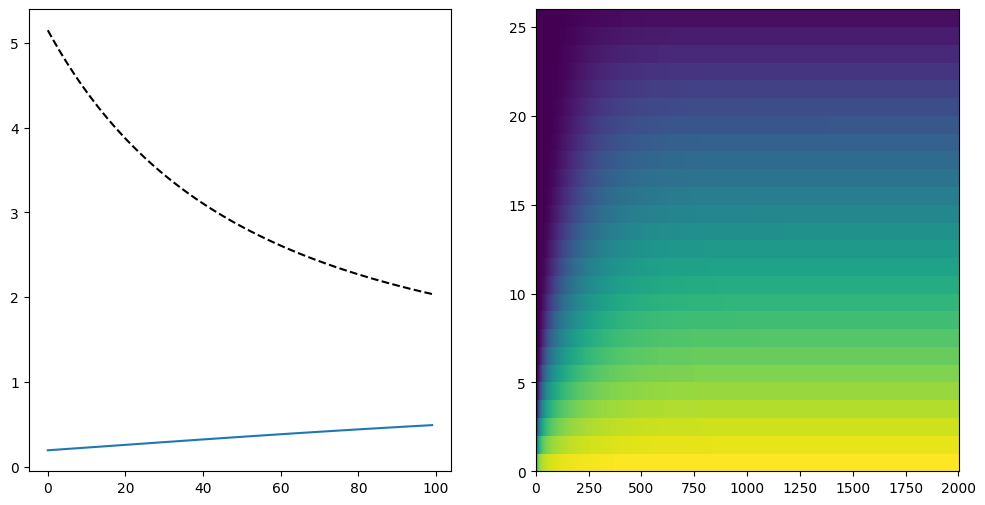

In [43]:
analytical_retardation_type = "langmuir"


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

u_ret = torch.linspace(0,1,100)
ret = ret_fun(u_ret).numpy().reshape(-1)
ax1.plot(ret)
ax1.plot(np.load(f"../data_out/{analytical_retardation_type}/default_finn/retardation_{analytical_retardation_type}.npy"), "k--")
ax2.pcolormesh(c[:, 0, :, 0].T, cmap="viridis")
plt.show()